# Final LDA Model

In [33]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # Author: don't skip this
# pyLDAvis.gensim.prepare

# I think i need another one:
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [34]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')
stop_words.extend(['tenlastelegging\\n\\n\\naan', '\\n\\n\\n\\n\\n\\n', '\\n\\n\\n\\n\\n', '\\n\\n', 'een', 'naan', 'nde', 'nhij', '\\n'])

# Data

In [35]:
# Data
df = pd.read_csv('DataSample_DSP_07123.csv', index_col=1) 
df = df[df['re_tll'] != '[]'][['re_tll']] #re_bewijs
# data = [i for i in df['re_tll']]

# Tokenize 

In [36]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['re_tll']))

print(data_words[:1])

[['tenlastelegging', 'naan', 'verdachte', 'is', 'ten', 'laste', 'gelegd', 'dat', 'nhij', 'in', 'of', 'omstreeks', 'de', 'periode', 'van', 'november', 'tot', 'en', 'met', 'november', 'in', 'arnhem', 'en', 'of', 'in', 'nederland', 'en', 'of', 'in', 'duitsland', 'en', 'of', 'in', 'oostenrijk', 'en', 'of', 'in', 'hongarije', 'opzettelijk', 'een', 'of', 'meer', 'minderjarige', 'te', 'weten', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'en', 'of', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'heeft', 'onttrokken', 'aan', 'het', 'wettig', 'over', 'hen', 'haar', 'gesteld', 'gezag', 'en', 'of', 'aan', 'het', 'opzicht', 'van', 'degene', 'die', 'dit', 'desbevoegd', 'over', 'hen', 'haar', 'uitoefende', 'terwijl', 'die', 'minderjarige', 'beneden', 'de', 'twaalf', 'jaren', 'oud', 'was', 'waren', 'en', 'of', 'terwijl', 'list', 'was', 'gebezigd', 'bestaande', 'uit', 'het', 'door', 'verdachte', 'aan', 'de', 'school', 'van', 'de', 'minderjarig', 'in', 'strijd',

# Creating Bigram and Trigram Models

In [37]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['tenlastelegging', 'naan', 'verdachte', 'is', 'ten_laste_gelegd', 'dat', 'nhij', 'in', 'of', 'omstreeks', 'de', 'periode', 'van', 'november', 'tot', 'en', 'met', 'november', 'in', 'arnhem', 'en', 'of', 'in', 'nederland', 'en', 'of', 'in', 'duitsland', 'en', 'of', 'in', 'oostenrijk', 'en', 'of', 'in', 'hongarije', 'opzettelijk', 'een', 'of', 'meer', 'minderjarige', 'te', 'weten', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'en', 'of', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'heeft', 'onttrokken', 'aan', 'het', 'wettig', 'over', 'hen', 'haar', 'gesteld', 'gezag', 'en', 'of', 'aan', 'het', 'opzicht', 'van', 'degene', 'die', 'dit', 'desbevoegd', 'over', 'hen', 'haar', 'uitoefende', 'terwijl', 'die', 'minderjarige', 'beneden', 'de', 'twaalf_jaren', 'oud', 'was', 'waren', 'en', 'of', 'terwijl', 'list', 'was', 'gebezigd', 'bestaande', 'uit', 'het', 'door', 'verdachte', 'aan', 'de', 'school', 'van', 'de', 'minderjarig', 'in', 'strijd', 'met', 'd

# Remove Stopwords, Make Bigrams and Lemmatize

In [38]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [39]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('nl', disable=['parser', 'ner'])

nlp = spacy.load("nl_core_news_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['tenlastelegging', 'verdenken', 'laste_gelegd', 'periode', 'oostenrijk', 'opzettelijk', 'minderjarig', 'weten', 'naam', 'baren', 'geboortedatum', 'geboorteplaats', 'naam', 'baren', 'geboortedatum', 'geboorteplaats', 'onttrekken', 'wettig', 'stellen', 'gezag', 'opzicht', 'desbevoegd', 'uitoefenen', 'minderjarig', 'twaalf_jar', 'oud', 'list', 'bezigen', 'bestaan', 'verdenken', 'school', 'minderjarig', 'strijd', 'waarheid', 'mededeel', 'minderjarig', 'afspraak', 'tandarts', 'minderjarig', 'daarvoor', 'vroeger', 'halen', 'school', 'verdenken', 'huis', 'lok', 'verdachte', 'echtgenote', 'genaamd', 'naam', 'maken', 'afspraak', 'woonboulevard', 'beweerdelijk', 'gaan', 'shopp', 'verdenken', 'paspoort', 'kleding', 'toiletartikel', 'minderjarig', 'woning', 'toverweging', 'aanzien', 'bewijs', 'feit', 'nop', 'grond', 'bewijsmiddel', 'volgen', 'ver', 'discussie_staat', 'vaststellen', 'naangeefst', 'naam', 'verdenken', 'trouwen', 'samen', 'kind', 'naam', 'baren', 'geboortedatum', 'geboorteplaats', 

#  Create the Dictionary and Corpus needed for Topic Modeling

In [40]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 4), (1, 1), (2, 1), (3, 1), (4, 4), (5, 1), (6, 1), (7, 4), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 5), (32, 4), (33, 4), (34, 1), (35, 2), (36, 3), (37, 1), (38, 4), (39, 1), (40, 1), (41, 1), (42, 2), (43, 10), (44, 2), (45, 1), (46, 3), (47, 1), (48, 1), (49, 3), (50, 2), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 6), (58, 1), (59, 10), (60, 1), (61, 1), (62, 1), (63, 4), (64, 1), (65, 1), (66, 1), (67, 3), (68, 2), (69, 2), (70, 2), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 4), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 2), (92, 1), (93, 1), (94, 2), (95, 1), (96, 4), (97, 1), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 4), (104, 1), (105, 1), (106, 1), (107, 4), (108, 1), (109, 1), (110, 

In [41]:
# Id word
id2word[0]

'aangeefster'

# Building the Topic Model

In [42]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in LDA model

In [30]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"ander" + 0.023*"althans" + 0.021*"naam" + 0.020*"verdenken" + '
  '0.016*"geval" + 0.015*"bedrijf" + 0.014*"goed" + 0.014*"weten" + '
  '0.012*"periode" + 0.012*"telkens"'),
 (1,
  '0.031*"verbalisant" + 0.023*"zien" + 0.021*"man" + 0.014*"medeverdacht" + '
  '0.012*"adres" + 0.011*"woning" + 0.009*"persoon" + 0.008*"uur" + '
  '0.008*"overval" + 0.007*"liggen"'),
 (2,
  '0.063*"verdenken" + 0.014*"hof" + 0.013*"rechtbank" + 0.012*"verklaren" + '
  '0.012*"benadelen" + 0.010*"gaan" + 0.010*"feit" + 0.009*"komen" + '
  '0.009*"zien" + 0.009*"medeverdacht"'),
 (3,
  '0.041*"naam" + 0.035*"verdenken" + 0.031*"aangeefster" + 0.022*"laten" + '
  '0.019*"zoon" + 0.013*"minderjarig" + 0.011*"kind" + 0.009*"telkens" + '
  '0.008*"huis" + 0.007*"gezag"'),
 (4,
  '0.096*"slachtoffer" + 0.038*"althans" + 0.030*"naam" + 0.024*"verdenken" + '
  '0.020*"ander" + 0.016*"geweld" + 0.014*"geval" + 0.012*"weten" + '
  '0.012*"lichaam" + 0.011*"hoofd"')]


# Compute Model Perplexity and Coherence Score

In [31]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.213709810029745

Coherence Score:  0.5126723333867096


# Visualize the topics-keywords

In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

C:\Users\Eveline Kalff\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.146325  0.052950       1        1  32.436806
4     -0.200337 -0.083271       2        1  27.691647
0     -0.176211 -0.093516       3        1  25.671490
3     -0.010647  0.281241       4        1   7.125917
1      0.240870 -0.157405       5        1   7.074139, topic_info=            Term          Freq         Total Category  logprob  loglift
584  slachtoffer  12255.000000  12255.000000  Default  30.0000  30.0000
59          naam   7173.000000   7173.000000  Default  29.0000  29.0000
171      althans   7219.000000   7219.000000  Default  28.0000  28.0000
695         zien   2011.000000   2011.000000  Default  27.0000  27.0000
112    verdenken  15145.000000  15145.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
154     richting    131.352878    743.370889   Topic5  -5.4519   0.9154
112    verdenken    198.687838  15145.828385   Topic5  -5.0381  -1.6850
399         hand    122.088760    616.526272   Topic5  -5.5251   1.0294
225   aantreffen    122.880398    675.888045   Topic5  -5.5186   0.9439
46         komen    124.109094   1648.590494   Topic5  -5.5086   0.0622

[379 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
0          4  0.998883         aangeefster
14661      5  0.974160             aanr_nl
225        1  0.362486          aantreffen
225        3  0.454217          aantreffen
225        4  0.002959          aantreffen
...      ...       ...                 ...
2850       5  0.990501    zover_inhoudenen
700        2  0.996549  zware_mishandeling
1144       1  0.087123               zwart
1144       3  0.043562               zwart
1144       5  0.866392               zwart

[632 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 4, 2])

# How to find the optimal number fo topics for LDA?

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [15]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

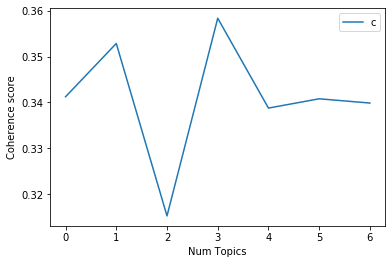

In [16]:
# Show graph

plt.plot(coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
coherence_values

[0.3412456880774918,
 0.35285554255841833,
 0.3152764177254558,
 0.3583540605690488,
 0.3387748899388256,
 0.34080056947872284,
 0.33987256479266986]